# Testing decoherence module in rsbeams

In [1]:
%matplotlib notebook

In [2]:
%matplotlib notebook
from cycler import cycler
from collections import OrderedDict
from rsbeams.rsphysics.decoherence import CentroidPosition
from scipy.integrate import dblquad
from multiprocessing import cpu_count, Pool

colors = ["xkcd:windows blue", "xkcd:amber", "xkcd:faded green", 
          "xkcd:dusty purple", "xkcd:blood orange", "xkcd:bluish grey", 
          "xkcd:carmine", "xkcd:greenish blue", "xkcd:wine",
          "xkcd:spruce"]

def subplots(x, y, **kwargs):
    array = np.ones([x, y])
    fig, array = plt.subplots(x, y, **kwargs)
    try:
        for plot in array.flat:
            plot.set_prop_cycle(cycler('color', colors))
    except AttributeError:
        array.set_prop_cycle(cycler('color', colors))
    
    return fig, array

In [3]:
# Numeric double integral functions
def gaussian_kicked(a, phi, Z):
    exp_term = -(a**2 + Z**2 - 2 * a * Z * np.cos(phi)) / 2.
    rho = 1 / (2 * np.pi) * a * np.exp(exp_term)
    
    return rho

def wb_kicked(a, phi, Z):
    maxa = 1.
    if a < maxa:
        rho =  -(1**2 + Z**2 - 2 * 1 * Z * np.cos(phi)) / maxa / np.pi
    else:
        rho = 0.
    return rho

def phase_quadratic(a, N, mu):
    return - 2 * np.pi * mu * a**2 * N #- 2 * np.pi * np.sqrt(mu) * a**4 * N / 100.

def phase_higher_order(a, N, *args):
    order = 2
    advance = 0
    for mu in args[0]:
        advance += mu * a**order
        order += 2
    phase = - 2 * np.pi * N * advance
    return phase

def arg_gaussian_centroid(a, phi, N, Z, nu0, mu):
    coeff = a * np.cos(phi)
    slip = phase_quadratic(a, N, mu)
    angle = phi - 2 * np.pi * nu0 * N - slip
    distr = gaussian_kicked(a, angle, Z)
    
    return coeff * distr

def arg_wb_centroid(a, phi, N, Z, nu0, mu):
    coeff = a * np.cos(phi)
    slip = phase_quadratic(a, N, mu)
    angle = phi - 2 * np.pi * nu0 * N - slip
    distr = wb_kicked(a, angle, Z)
    
    return coeff * distr

def arg_wb_centroid_arb_order(a, phi, N, Z, nu0, mu):
    """
    mu must be iterable list of values for amplitudes order 2,4,8,...
    """
    coeff = a * np.cos(phi)
    slip = phase_higher_order(a, N, mu)
    angle = phi - 2 * np.pi * nu0 * N - slip
    distr = wb_kicked(a, angle, Z)
    
    return coeff * distr

def integrate(arg):
    n, nu0, mu, Z = arg
    result, _ = dblquad(arg_wb_centroid, 0, 2*np.pi,
                           lambda x: 0,
                           lambda x: 20,
                           args=(n, Z, nu0, mu))
    return result

def integrate_arb_order(arg):
    n, nu0, mu, Z = arg
    result, _ = dblquad(arg_wb_centroid_arb_order, 0, 2*np.pi,
                           lambda x: 0,
                           lambda x: 20,
                           args=(n, Z, nu0, mu))
    return result

def integrate_wb_centroid(nu0, mu, Z, N=150):
    pool = Pool(cpu_count())
#  attempt to speed things up by spreading out difficult integration values at the end of range
#  appeared to not work
#     x = []
#     for i in range(cpu_count()):
#         x += range(N)[i::4]
    x = range(N)
    data = []
    for i in x:
        data.append((i, nu0, mu, Z))
    results = pool.map(integrate, data)
    pool.close()
    return results

def integrate_wb_centroid_arb_order(nu0, mu, Z, N=150):
    pool = Pool(cpu_count())
#  attempt to speed things up by spreading out difficult integration values at the end of range
#  appeared to not work
#     x = []
#     for i in range(cpu_count()):
#         x += range(N)[i::4]
    x = range(N)
    data = []
    for i in x:
        data.append((i, nu0, mu, Z))
    results = pool.map(integrate_arb_order, data)
    pool.close()
    return results

In [4]:
# Numeric single integration (over action) functions (integration over angle performed analytically)
def reduced_integrand(a, N, Z, nu0, mu):
    if N == 0:
        return Z / (2 * np.pi)
    
    order = 1
    advance = 0
    for m in mu:
        advance += m * a**order / (2. * np.pi * N)**(order - 1)
        order += 1
    advance = -advance

    coeff = Z / (2 * N)
    const_slip = 2 * np.pi * nu0 * N
    angular_term = np.cos(const_slip) * np.cos(advance) - np.sin(const_slip) * np.sin(advance)
    
    # Calculate cutoff if a is float or array
    try:
        maxa = 1. * 2 * np.pi * N
        if a <= maxa:
            distr = angular_term / 1. / np.pi
        else:
            distr = 0.
    except ValueError:
        maxa = np.ones_like(a, dtype='float') * 2 * np.pi * N
        distr = angular_term / 1. / np.pi * np.less(a, maxa)
    
    
    return coeff * distr

def integrate_1d(arg):
    n, nu0, mu, Z = arg
    if n == 0:
        return Z
    
    result, _ = quad(reduced_integrand,
                     0, 2*np.pi * n, 
                     args=(n, Z, nu0, mu))
    return result

def integrate_wb_centroid_1d(nu0, mu, Z, N=150):
    pool = Pool(8)
#  attempt to speed things up by spreading out difficult integration values at the end of range
#  appeared to not work
#     x = []
#     for i in range(cpu_count()):
#         x += range(N)[i::4]
    x = range(N)
    data = []
    for i in x:
        data.append((i, nu0, mu, Z))
    results = pool.map(integrate_1d, data)
    pool.close()
    
    return results

# Compare New Integration Methods with Old

If available show zero-current Waterbag simulations in IOTA with 100 $\mu m $ injection offset

In [5]:
# rms x beam sizes at start in mm

rms_x={ 4: 0.6290217848610999,
        8: 0.9070459284620859,
        12: 1.126394573412305,
        16: 1.320911252791467}

In [22]:
try:
    zc_centroids = h5.File('ZC_centroids_waterbag_t0p4_c0p01_4-16um_1000turns.h5', 'r')
    zc = OrderedDict()
    for i in range(4, 17, 4):
        zc[i] = zc_centroids[str(i)]
    plot_simulation = True
except IOError:
    print('Centroid data not found. Will not include simulation data in plots.')
    plot_simulation = False

### Up to $a^2$

<IPython.core.display.Javascript object>


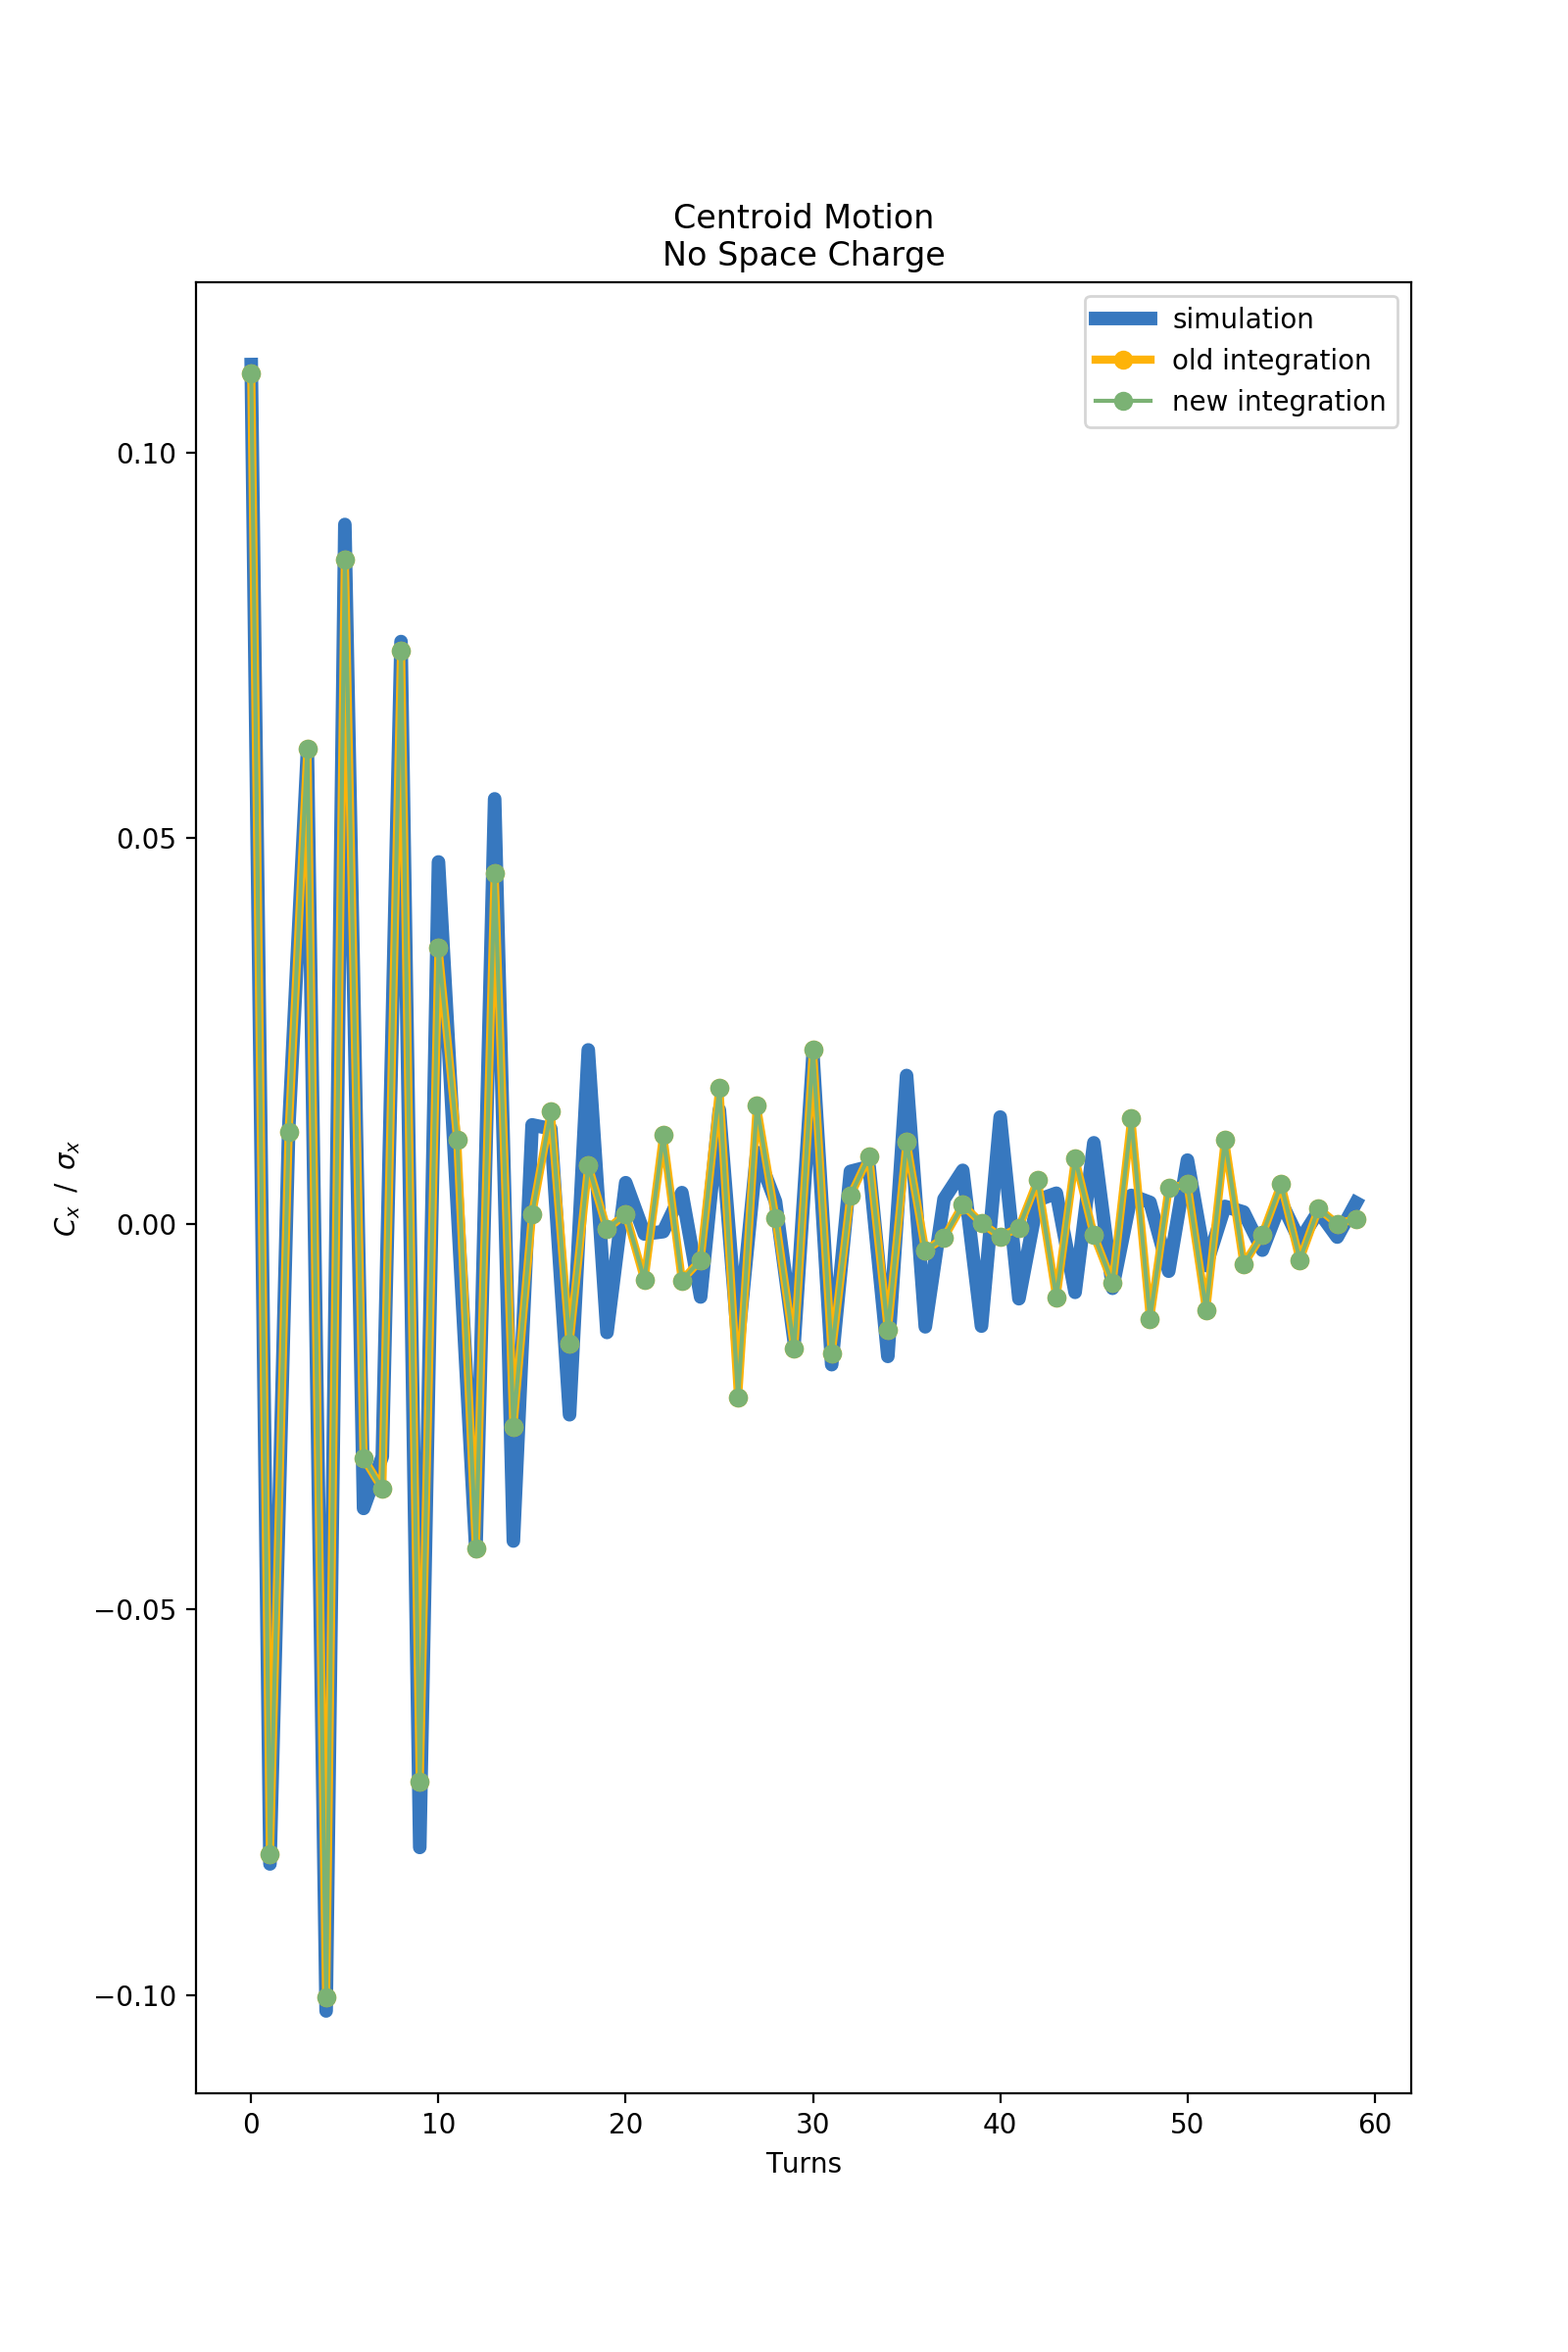

In [8]:
fig_centroids, ax1 = subplots(1, 1, figsize=(8, 12))
key = 8
nu0 = 5.40941361
mu = [0.05131625,]
Z =  0.1 / rms_x[key]

if plot_simulation:
    ax1.plot(zc[key]['turn'][0:60], 
             zc[key]['centroid'][0:60] / rms_x[key],
             linewidth=5,
             label='simulation')
# Purely numeric integration for a**2
old_integration = integrate_wb_centroid_arb_order(nu0, mu, Z, N=60)
ax1.plot(range(0,60), old_integration, marker='o', linewidth=3, label='old integration')

# Analytic integration for a**2
wb_8 = CentroidPosition(60, Z, nu0, mu)
ax1.plot(range(0,60), wb_8.calculate_centroids(), marker='o', label='new integration')

ax1.set_xlabel('Turns')
ax1.set_ylabel('$C_x \, \, \, / \, \,\, \sigma_x$')
ax1.set_title("Centroid Motion\nNo Space Charge")
ax1.legend()

plt.show()

### Up to $a^4$

<IPython.core.display.Javascript object>


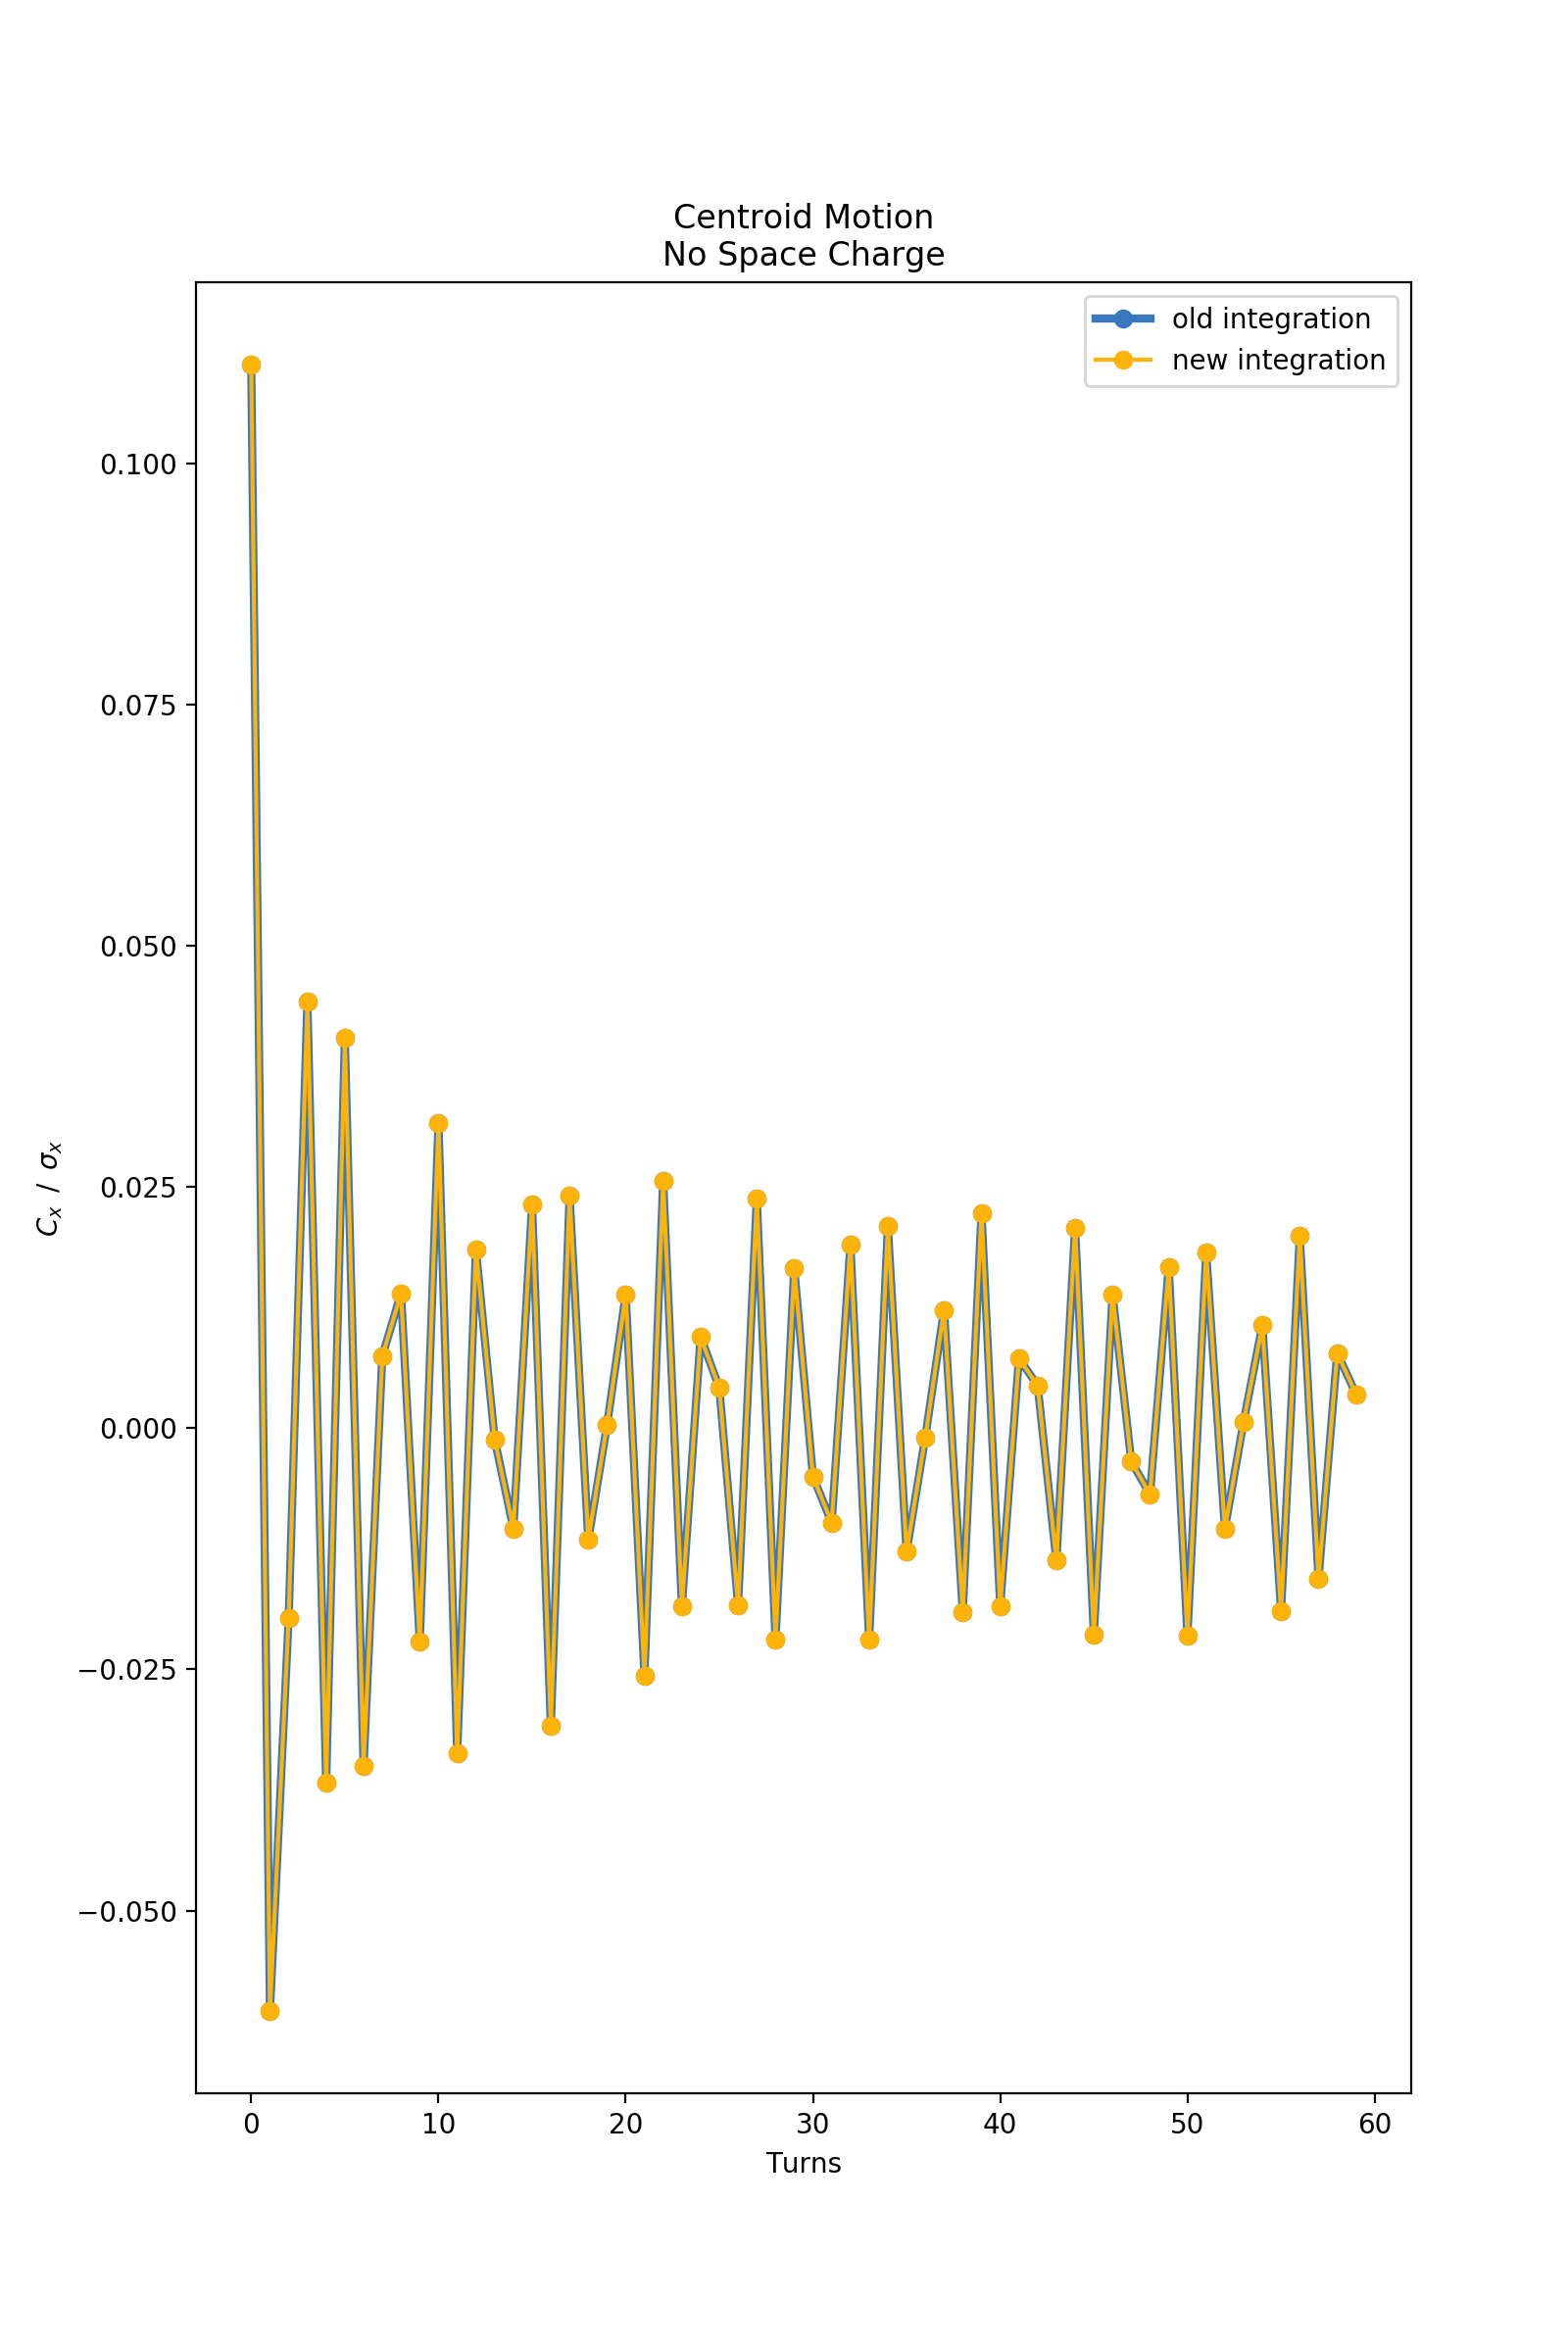

In [15]:
fig_centroids, ax1 = subplots(1, 1, figsize=(8, 12))
key = 8

# No fit of first two orders was available at this time
# These numbers are just made up for this comparison and will not match up against simulation data
nu0 = 5.40941361
mu = [-0.05131625, 5 * 0.05131625]
Z =  0.1 / rms_x[key]

# Purely numerical integration up to a**4
old_integration = integrate_wb_centroid_arb_order(nu0, mu, Z, N=60)
ax1.plot(range(0,60), old_integration, marker='o', linewidth=3, label='old integration')

# Analytic result for integration up to a**4
wb_8 = CentroidPosition(60, Z, nu0, mu)
ax1.plot(range(0,60), wb_8.calculate_centroids(), marker='o', label='new integration')

ax1.set_xlabel('Turns')
ax1.set_ylabel('$C_x \, \, \, / \, \,\, \sigma_x$')
ax1.set_title("Centroid Motion\nNo Space Charge")
ax1.legend()

plt.show()

### Timing comparisons

In [23]:
from scipy.integrate import quadrature
test_turn = 5

print wb_8.integrate_second_order(turn=test_turn)
print quadrature(reduced_integrand, 0, 2*np.pi * 5, args=(test_turn, Z, nu0, 
                                                          mu), maxiter=500)

0.04041943232299223
(0.040419435114328314, 7.519240438624841e-10)


In [18]:
%%timeit
wb_8.integrate_second_order2(turn=test_turn)

100000 loops, best of 3: 16.5 µs per loop


In [19]:
%%timeit
quadrature(reduced_integrand, 0, 2*np.pi * 5, args=(test_turn, Z, nu0, 
                                                          mu), maxiter=500)

1000 loops, best of 3: 517 µs per loop


### Up through $a^6$

In [ ]:
fig_centroids, ax1 = subplots(1, 1, figsize=(8, 12))
key = 8

# No fit of first two orders was available at this time
# These numbers are just made up for this comparison and will not match up against simulation data
nu0 = 5.40941361
mu = [-0.05131625, 5 * 0.05131625, -0.05131625]
Z =  0.1 / rms_x[key]

# Purely numerical integration up to a**4
old_integration = integrate_wb_centroid_arb_order(nu0, mu, Z, N=60)
ax1.plot(range(0,60), old_integration, marker='o', linewidth=3, label='old integration')

# Analytic result for integration up to a**4
wb_8 = CentroidPosition(60, Z, nu0, mu)
ax1.plot(range(0,60), wb_8.calculate_centroids(), marker='o', label='new integration')

ax1.set_xlabel('Turns')
ax1.set_ylabel('$C_x \, \, \, / \, \,\, \sigma_x$')
ax1.set_title("Centroid Motion\nNo Space Charge")
ax1.legend()

plt.show()